# Impact Calculation Using CLIMADA: Flood Event Data from Saferplaces and RIM2D: EXAMPLE 1

In this notebook, we demonstrate how to calculate the impact of a **single flood event** using **CLIMADA**, with data from the **Saferplaces model** (Rimini) and the **RIM2D model** (Denmark).

### Key Points:
- We use residential building shapefiles from Rimini and Denmark:
  - **Rimini demo**: Using the provided residential shapefile (not the "Rimini_32633" file).
  - **Denmark**: Using the **"buildings_denmark.shp"** shapefile.
  
- Due to the large size and high resolution of the flood data:
  - **Saferplaces**: 1 x 1 m resolution.
  - **RIM2D**: 5 x 5 m resolution.
  
  Instead of creating a full hazard object for the entire raster, we generate a **reduced hazard object** by averaging the **water level within a 20-meter buffer** around each building's centroid. This reduction speeds up the impact calculation, though the hazard object is limited in scope.

### Two Methods for Hazard Generation:

**Method 1**: Create a **reduced hazard object** directly using the building shapefile and importing the raster. The full hazard object can be imported later if needed (shown in notebook).

**Method 2**: First, create a **full hazard object** from the entire raster and then project it onto a **reduced hazard object** using the shapefile. This method allows for more flexibility in visualizing and analyzing the hazard.

### Objective:
- The two methods are compared to determine which is more efficient in terms of data handling in the data matrix, and whether storing a full hazard object is necessary for plotting and further analysis.



### Pre-processing of .asc files

The `.asc` file provided by RIM2D was converted to `.tif` using the following script:

```python
import subprocess

# Define the output .tif file name
asc_file = haz_raster_file
tif_file = haz_raster_file.replace('.asc', '.tif')

# Set the paths to the .asc and .tif files
asc_path = data_path / haz_folder / asc_file  # Path to the .asc file
tif_path = data_path / haz_folder / tif_file  # Path to the output .tif file

# Convert .asc to .tif using gdal_translate
orig_crs = 'EPSG:25832' # Provided by RIM2D for Denmark
cmd = ['gdal_translate', '-of', 'GTiff', '-a_srs', orig_crs, str(asc_path), str(tif_path)]
subprocess.run(cmd, check=True)
print(f"GeoTIFF saved as {tif_path}")


**Define the path to DATA folder. The DATA can be downloaded from NEXTCLOUD [https://cloud.tu-braunschweig.de/f/569399210](https://cloud.tu-braunschweig.de/f/569399210)**   

In [1]:
from pathlib import Path
import os

# Define the base data path
data_path = Path('/Users/vwattin/Documents/Programming/Climate/DIRECTED/Coupling/DATA')

# Define the Results folder inside the data path
results_path = data_path / 'Results'

# Create the Results folder if it doesn't exist
results_path.mkdir(parents=True, exist_ok=True)

# Get the current file name (dynamically from __file__ or manually set it)
# If running in Jupyter Notebook or an interactive environment, you can set the name manually
current_file_name = 'CLIMADA-Saferplaces&RIM2D_example1_new'

# Create a folder inside Results with the same name as the current working file
output_path = results_path / current_file_name
output_path.mkdir(parents=True, exist_ok=True)

print(f"Results will be stored in: {output_path}")


Results will be stored in: /Users/vwattin/Documents/Programming/Climate/DIRECTED/Coupling/DATA/Results/CLIMADA-Saferplaces&RIM2D_example1_new


#### Determine the demo (corresponding to the exposure and hazard file)

In [2]:
# Parameters
# Define the name of the demo to run
demo = 'Saferplaces' # 'Saferplaces' or 'RIM2D'

# Define the input building file and hazard file
if demo == 'Saferplaces':

    # Define the input building file 
    exp_folder = 'Saferplaces/Exposure/DMG_RAIN161922'
    building_file = 'DMG_RAIN161922.shp' #'OSM_BUILDINGS_161124.shp'

    # Define the input hazard file
    haz_folder = 'Saferplaces/Hazard'  # Folder where the raster file is located
    haz_raster_file = 'WD_RAIN161922.tif'  # Raster file name (.tif format)buffer_distance = 20  # Buffer distance for each building (in meters)

elif demo == 'RIM2D':

    # Define the input building file 
    exp_folder = 'RIM2D/Denmark_results/buildings_denmark'
    building_file = 'buildings_denmark.shp' #'OSM_BUILDINGS_161124.shp'

    # Define the input hazard file
    haz_folder = 'RIM2D/Denmark_results'  # Folder where the raster file is located
    haz_raster_file = 'Coastal_2013Storm_wd_max.tif'  # Raster file name (.tif format)buffer_distance = 20  # Buffer distance for each building (in meters)

### Create the Exposure Object

We will now define the exposure object using the provided building shapefile. 

In [3]:
from climada.entity import Exposures
import geopandas as gpd
import numpy as np


# Folder where the file is located
shape_file = data_path / exp_folder / building_file
# Load the shapefile into a GeoDataFrame
exp_gdf = gpd.read_file(shape_file)

# Add a 'value' column to the GeoDataFrame (required by CLIMADA)
if demo == 'Saferplaces':
    exp_gdf['value'] = exp_gdf['exposure']  # Set the value column to the 'exposure' column
elif demo == 'RIM2D':
    exp_gdf['value'] = 1 # Set the value column to 1

# Store the original geometry in a new column
exp_gdf['geometry_polygon'] = exp_gdf['geometry']

# Set the geometry to the centroid of the building (useful for impact calculations later on)
exp_gdf['geometry'] = exp_gdf['geometry'].centroid
# Now, reproject the centroids back to EPSG:4326 (WGS84, in degrees)
exp_gdf = exp_gdf.to_crs(4326)  # EPSG:4326 for latitude/longitude, also  CLIMADA default CRS
# Set the geometry to the centroid of the building
exp_gdf['latitude'] = exp_gdf['geometry'].y
exp_gdf['longitude'] = exp_gdf['geometry'].x

# Display the first row of the GeoDataFrame (not necessary, but useful to see the data contained)
#print(exp_gdf.iloc[0])

# Define the exposure object
exp = Exposures(exp_gdf)

# Check the exposure object
exp.check()

*Note: In the code above, we change the main geometry of the exposure object to be a centroid (to simplify the impact calculation later on) while keeping the original polygon geometry. CLIMADA can handle exposure objects as polygons for plotting and impact calculations, but they should be treated in certain ways. See [How to use polygons or lines as exposure](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_Exposures_polygons_lines.html#polygons).*


#### Define the Impact function and impact function set

Here, we use the same residental impact function uside in the Saferplaces Rimini example

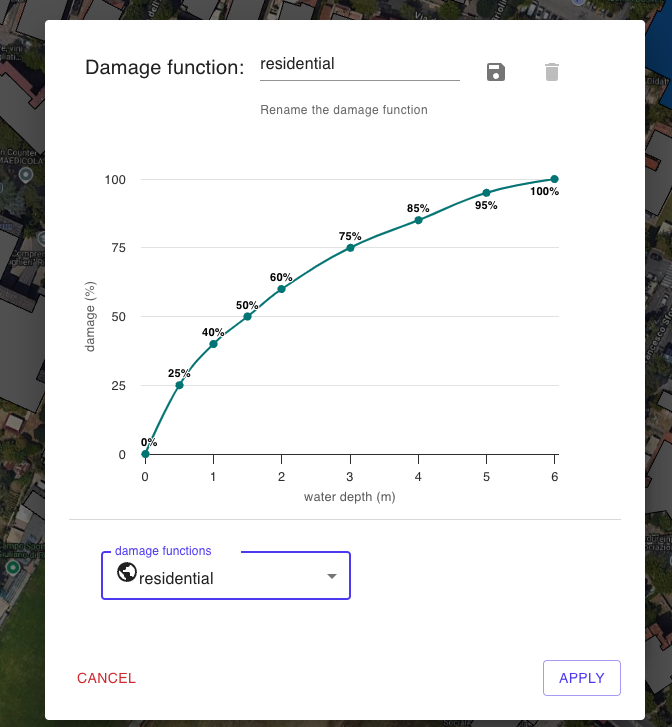

Now, this function is created manually using CLIMADA, but can later on be created by importing an excel file directly into CLIMADA.

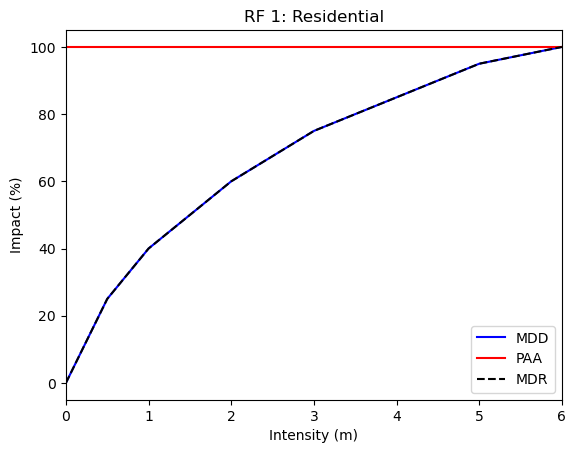

In [4]:
import numpy as np
from climada.entity import ImpactFunc, ImpactFuncSet

# Define the impact function parameters
haz_type = 'RF'  # Type of the hazard, ideally a two-letter identifier
impf_id1 = 1  # Identifier of the event
intensity = np.array([0, 0.5, 1, 1.5, 2.0, 3.0, 4.0, 5.0, 6])  # Intensity values from the plot
mdd = np.array([0, 25, 40, 50, 60, 75, 85, 95, 100]) * (1/100)
paa = np.ones(len(intensity))
intensity_unit = "m"  # Unit of intensity, just for plots
name = 'Residential'  # Name of the impact function

# Create an ImpactFunc object
impf1 = impact_func = ImpactFunc(
    haz_type= haz_type, # Type of the hazard
    id = impf_id1, # Identifier of the event
    intensity = intensity, # Intensity values
    mdd = mdd, # Mean damage distribution
    paa = paa, # Probability of being in each damage state
    intensity_unit = intensity_unit, # Unit of intensity
    name = name # Name of the impact function
)

# Define the impact function set
impfset = ImpactFuncSet([impf1])

#  Plot the impact functions
impfset.plot()

# Check the impact function set
impfset.check()

An impact function set can also be saved and uploaded in CLIMADA

In [5]:
# Store an excel file 
impfset.write_excel(output_path / f'impact_fcn_set_{demo}_example1.xlsx')

# Read the impact function set from excel
impfset = ImpactFuncSet.from_excel(output_path / f'impact_fcn_set_{demo}_example1.xlsx')

We need to assign the impact functions to the exposure points.

In [6]:
exp.gdf[f'impf_{haz_type}'] = impf_id1 # Assign the impact function to the exposure object with threshold 1

### Creating the Hazard Object

We create a hazard object by reading the raster file provided by Saferplaces and projecting the average water level onto the exposure centroids of the buildings.

This process involves the following steps:

1. **Create a 20-meter buffer zone** around each building to capture the surrounding area affected by water.
2. **Calculate the average water level** within this buffer zone based on the raster data. This is done by calculating the total water level from the water pixels (excluding NaN and the building pixels from teh shape file) and then dividing by the total number of water pixels that satisfy these conditions.
3. **Represent each building by its centroid** and project the calculated average water level onto that centroid.
4. This approach is inspired by the **SAFERPLACES methodology**.

**Important to note**: For the impact calculation the entire hazard map in the raster file is not used but reduces it to solely on the centroids corresponding to each building. Thus we refer to it as a *dummy* hazard

Below is an illustrative figure showing the distribution of water around a building (white square):

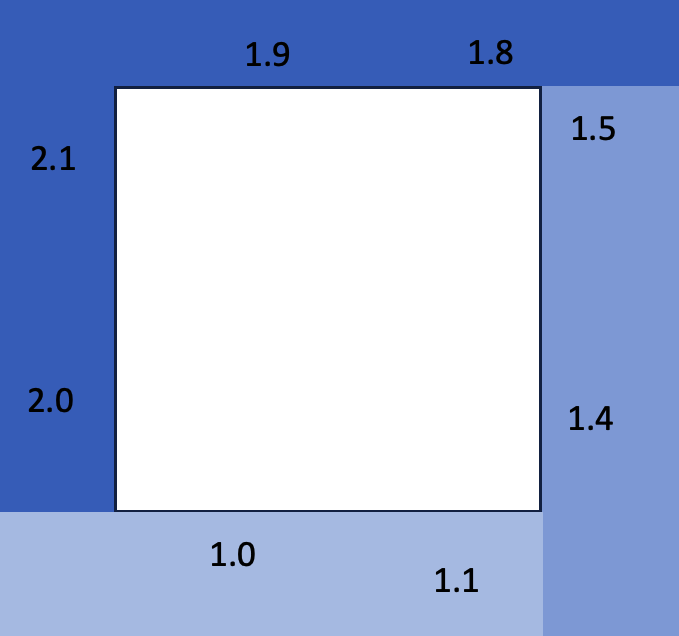


In [7]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, box
import numpy as np
from climada.hazard import Hazard, Centroids
from scipy.sparse import csr_matrix
import time

# ---- Step 1: Define Parameters ----
# Define the file path and parameters
hazard_type = 'RF'  # Type of the hazard, ideally a two-letter identifier
intensity_unit = 'm'  # Unit of intensity, just for plots
n_ev = 1  # Number of events
frequency = np.ones(n_ev) / 1000  # Arbitrary frequency of the event
event_id = np.arange(1, dtype=int)  # Event ID (e.g., 1 event in this case)
frequency = np.ones(1) / 1000  # Frequency of the event (arbitrarily set to 1-in-1000 year)
# Define the buffert ...
buffer_distance = 20  # Buffer distance for each building (in meters)

# ---- Step 2: Copy Exposure Data and Prepare for Processing ----
haz_dummy_gdf = exp.gdf[['geometry', 'geometry_polygon']].copy()

# ---- Step 3: Open the Raster File and Get CRS ----
hazard_raster_full_path = data_path / haz_folder / haz_raster_file
with rasterio.open(hazard_raster_full_path) as src:
    raster_crs = src.crs # Assume the raster CRS is not geographic (e.g., UTM)
    raster_bounds = src.bounds
    raster_nodata = src.nodata

# ---- Step 4: Apply Buffer to Building Geometries ----
# If the GeoDataFrame CRS does not match the raster CRS, reproject it
if haz_dummy_gdf.crs != raster_crs:
    haz_dummy_gdf = haz_dummy_gdf.to_crs(raster_crs)
    print(f"Reprojected GeoDataFrame to match the raster CRS: {raster_crs}")
haz_dummy_gdf['geometry_polygon_buffered'] = haz_dummy_gdf['geometry_polygon'].buffer(buffer_distance)

# Convert raster bounds to a Shapely Polygon for intersection checking
raster_bounds_polygon = box(raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top)

# ---- Step 5: Define Function to Calculate Mean Water Depth, Excluding Building Area ----
def calculate_mean_water_excluding_building(geom, building_geom, src, raster_nodata, raster_bounds_polygon):
    '''
    This function calculates the mean water depth (intensity) within the buffered area around a building,
    excluding water pixels that fall within the building polygon itself.

    It masks the raster (water depth) data to the area covered by the building's buffer, subtracts the building geometry,
    and calculates the average water depth over the remaining valid pixels.

    Parameters:
    - geom: The geometry of the buffered building (Polygon).
    - building_geom: The original building geometry to exclude water pixels inside.
    - src: The raster dataset (opened .tif file) containing water depth values.
    - raster_nodata: The value that represents missing or "no data" in the raster file.
    - raster_bounds_polygon: The bounding box of the raster file as a Shapely Polygon.
    
    Returns:
    - The mean water depth within the buffer area of the building, excluding the building polygon, or 0 if no valid water pixels are found.
    '''
    # Check if the buffered building geometry intersects the raster area
    if geom.intersects(raster_bounds_polygon):
        # Create a new geometry by subtracting the building geometry from the buffered area
        buffer_minus_building = geom.difference(building_geom)
        
        if buffer_minus_building.is_empty:
            return 0  # If there's no area left after subtracting the building, return 0
        
        # Convert the buffered-minus-building geometry to GeoJSON for raster masking
        geom_geojson = [mapping(buffer_minus_building)]
        
        # Mask the raster using the adjusted geometry (buffer minus building), and extract water depth values
        out_image, _ = mask(src, geom_geojson, crop=True, nodata=raster_nodata)
        water_pixels = out_image.flatten()

        # Filter out invalid values (nodata and handle NaNs), but include zero water pixels
        valid_water_pixels = water_pixels[(water_pixels != raster_nodata)]

        # Return the mean water depth if valid water pixels exist, otherwise return 0
        if valid_water_pixels.size == 0 or np.isnan(valid_water_pixels).all():
            return 0  # Return 0 if all valid water pixels are NaN or if there are no valid water pixels
        return np.nanmean(valid_water_pixels)
    else:
        # If the building doesn't intersect with the raster, return 0
        return 0

# ---- Step 6: Apply the Mean Water Calculation to Each Buffered Building Geometry ----
with rasterio.open(hazard_raster_full_path) as src:
    # Apply the mean water calculation function to each buffered building geometry
    haz_dummy_gdf['mean_water'] = haz_dummy_gdf.apply(
        lambda row: calculate_mean_water_excluding_building(
            row['geometry_polygon_buffered'], row['geometry_polygon'], src, raster_nodata, raster_bounds_polygon
        ),
        axis=1
    )

# ---- Step 7: Reproject Back to Geographic CRS (EPSG:4326) ----
haz_dummy_gdf = haz_dummy_gdf.to_crs(4326) 

# ---- Step 8: Create the Hazard Object for CLIMADA ----
haz_dummy = Hazard(
    haz_type=hazard_type,
    intensity=csr_matrix([haz_dummy_gdf["mean_water"]]),
    centroids=Centroids(lat=haz_dummy_gdf.geometry.centroid.y, lon=haz_dummy_gdf.geometry.centroid.x, crs='EPSG:4326'),
    units=intensity_unit,
    event_id=event_id,
    frequency=frequency
)

# ---- Step 9: Validate the Hazard Object ----
haz_dummy.check()


Reprojected GeoDataFrame to match the raster CRS: EPSG:32633


/var/folders/cc/c55t39cs0_7dn2cdqsg62v4c0000gp/T/ipykernel_81827/635048756.py:102: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=Centroids(lat=haz_dummy_gdf.geometry.centroid.y, lon=haz_dummy_gdf.geometry.centroid.x, crs='EPSG:4326'),


Then we compute the impacts

In [8]:
from climada.engine import ImpactCalc
impcalc = ImpactCalc(exposures=exp, impfset=impfset, hazard=haz_dummy)

In [9]:
impact = impcalc.impact()

The impact matrix can also be saved

In [10]:
# Save the full event/point impact matrix in sparse format
impact.write_sparse_csr(output_path / f'impact_{demo}_example1_impmat.npz')

#### Create hazard file based on entire raster file

As a side note, if one wishes to upload the full raster file as a Hazard object using the CLIMADA methods, the following code can be used. Note the difference in speed—it takes minutes compared to seconds for the Saferplaces .tif file.

- For Saferplaces – We create a gdf of the raster file and remove all the nan values.
- For RIM2D – it seems faster to use the default CLIMADA method.


In [11]:
from shapely.geometry import Point
import pandas as pd

if demo == 'RIM2D':
    # Define the file path and parameters

    # Create a Hazard object from the .tif file using the from_raster method
    haz = Hazard.from_raster(
        files_intensity=[str(hazard_raster_full_path)],  # The function expects a list of file paths
        haz_type=hazard_type,  # Set the hazard type
        dst_crs="EPSG:4326"  # Reproject to the intended CRS if necessary
        # resampling=rasterio.warp.Resampling.nearest  # Resampling method if reprojection is needed
    )

elif demo == 'Saferplaces':

    # Step 1: Open the .tif file using rasterio
    with rasterio.open(hazard_raster_full_path) as src:
        # Read the raster data as an array
        raster_data = src.read(1)  # Read the first band, if it's a multi-band raster
        # Get the affine transformation (to convert pixel coordinates to real-world coordinates)
        transform = src.transform
        # Get the CRS (Coordinate Reference System)
        crs = src.crs

    # Step 2: Create pixel coordinates
    rows, cols = np.where(~np.isnan(raster_data))  # Get row/col indices where data is NOT NaN

    # Step 3: Convert row/col to real-world coordinates using the affine transformation
    xs, ys = rasterio.transform.xy(transform, rows, cols)

    # Step 4: Create a GeoDataFrame with the coordinates and pixel values
    geometry = [Point(x, y) for x, y in zip(xs, ys)]
    pixel_values = raster_data[rows, cols]

    # Step 5: Create a pandas DataFrame and then convert to a GeoDataFrame
    df = pd.DataFrame({'value': pixel_values, 'geometry': geometry})
    haz_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs)

    # Step 6: Remove rows where pixel values are NaN (if any remain)
    haz_gdf = haz_gdf.dropna(subset=['value'])

    # Step 7: Reproject the GeoDataFrame to EPSG:4326 (WGS 84)
    haz_gdf = haz_gdf.to_crs('EPSG:4326')

    # Extract the latitudes, longitudes, and intensity values from the GeoDataFrame
    lat = haz_gdf.geometry.y.values  # Extract latitudes from geometry
    lon = haz_gdf.geometry.x.values  # Extract longitudes from geometry
    values = haz_gdf['value'].values  # Extract the intensity values

    # Convert the intensity values to a sparse matrix
    intensity = csr_matrix(values.reshape(1, -1))  # 1D array of intensity values reshaped for the event

    # Create the Hazard object
    haz = Hazard(
        haz_type='RF',  # Assuming 'RF' for rainfall; adjust as needed
        intensity=intensity,  # Intensity matrix
        centroids=Centroids(lat=lat, lon=lon, crs='EPSG:4326'),  # Centroids from lat/lon
        units=intensity_unit,  # Units of the hazard intensity
        event_id=event_id,  # Event ID array (1 event)
        frequency=frequency  # Event frequency
    )

# Perform a check to ensure the hazard object is correctly created
haz.check()


### Create a dummy hazard based on the full hazard object and the shape file

In [12]:
# Step 1: Define Input Parameters
haz_dummy_gdf = exp.gdf[['geometry', 'geometry_polygon']].copy()  # Exposure GeoDataFrame

# Ensure both GeoDataFrame and raster data are in the same CRS
if haz_dummy_gdf.crs != raster_crs:
    haz_dummy_gdf = haz_dummy_gdf.to_crs(raster_crs)
    print(f"Reprojected GeoDataFrame to match the raster CRS: {raster_crs}")

# Step 2: Apply buffer around building geometries
haz_dummy_gdf['geometry_buffert'] = haz_dummy_gdf['geometry_polygon'].buffer(buffer_distance)
haz_dummy_gdf = haz_dummy_gdf.set_geometry('geometry_buffert')  # Use buffer for spatial joins

# Step 3: Prepare Hazard Centroids GeoDataFrame
haz_centroid_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(haz.centroids.lon, haz.centroids.lat), crs=haz.centroids.crs)
haz_centroid_gdf = haz_centroid_gdf.to_crs(raster_crs)

# Function to get centroids inside the buffer zone
def get_centroids_inside(gdf, centroid_gdf, geometry_column):
    gdf = gdf.set_geometry(geometry_column)  # Set active geometry to buffer
    joined = gpd.sjoin(centroid_gdf, gdf, how='left', predicate='within')
    grouped = joined.groupby('index_right').apply(lambda x: list(x.index)).reindex(gdf.index, fill_value=[])
    gdf = gdf.set_geometry('geometry')  # Reset to original geometry
    return grouped

# Get centroids within buffer and building polygons
haz_dummy_gdf['haz_centroid_indices_buffer'] = get_centroids_inside(haz_dummy_gdf, haz_centroid_gdf, 'geometry_buffert')
haz_dummy_gdf['haz_centroid_indices_original'] = get_centroids_inside(haz_dummy_gdf, haz_centroid_gdf, 'geometry_polygon')

# Subtract to find centroids in the buffer but not in the original building
haz_dummy_gdf['haz_centroid_indices'] = haz_dummy_gdf['haz_centroid_indices_buffer'].apply(set) - haz_dummy_gdf['haz_centroid_indices_original'].apply(set)
haz_dummy_gdf['haz_centroid_indices'] = haz_dummy_gdf['haz_centroid_indices'].apply(list)

# Clean up temporary columns
haz_dummy_gdf.drop(columns=['geometry_buffert', 'geometry_polygon', 'haz_centroid_indices_buffer', 'haz_centroid_indices_original'], inplace=True)
haz_dummy_gdf = haz_dummy_gdf.set_geometry('geometry')  # Reset to centroid geometry

# Step 4: Calculate mean intensity for centroids in buffer
n_events = len(haz.event_id)
n_buildings = len(haz_dummy_gdf)
dummy_intensity_matrix = np.zeros((n_events, n_buildings))

intensity_matrix = haz.intensity.toarray()  # Extract hazard intensity matrix

for idx, row in haz_dummy_gdf.iterrows():
    centroid_indices = row['haz_centroid_indices']
    if centroid_indices:
        dummy_intensity_matrix[:, idx] = np.mean(intensity_matrix[:, centroid_indices], axis=1)  # Calculate mean ignoring NaN
    else:
        dummy_intensity_matrix[:, idx] = 0  # Set to 0 if no centroids

# Step 5: Reproject back to EPSG:4326
haz_dummy_gdf = haz_dummy_gdf.to_crs('EPSG:4326')

# Step 6: Create Hazard Object with New Intensity Matrix
haz_dummy = Hazard(
    haz_type=haz.haz_type,
    intensity=csr_matrix(dummy_intensity_matrix),
    centroids=Centroids(lat=haz_dummy_gdf.geometry.centroid.y, lon=haz_dummy_gdf.geometry.centroid.x, crs=haz_dummy_gdf.crs),
    units=haz.units,
    event_id=haz.event_id,
    frequency=haz.frequency
)

# Step 7: Validate the Hazard Object
haz_dummy.check()


Reprojected GeoDataFrame to match the raster CRS: EPSG:32633


/var/folders/cc/c55t39cs0_7dn2cdqsg62v4c0000gp/T/ipykernel_81827/1204890068.py:58: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=Centroids(lat=haz_dummy_gdf.geometry.centroid.y, lon=haz_dummy_gdf.geometry.centroid.x, crs=haz_dummy_gdf.crs),


Compare the results to the previous method

We obtain the total loss from each event from the `at_event` array (which in this case contains only one event) and the number of houses impacted from the impact matrix `imp_mat`.

*Note: That the file `DMG_RAIN161922.shp` from Saferplaces. already contains impact calculations made in Saferplaces, as well as the necessary varibels to derive these, e.g., mean_water, sum_water, wet [px], bld [px], that are used for the saferplaces impact calculations (see print(exp_gdf.iloc[0]) ).* 

In [13]:
from tabulate import tabulate


# Perform the new impact calculation using the CLIMADA method
impcalc = ImpactCalc(exposures=exp, impfset=impfset, hazard=haz_dummy)
impact_method2 = impcalc.impact()

# Gather the values for both CLIMADA methods
climada_total_impact = impact.at_event.sum()  # Total impact (only one event)
climada_houses_impacted = (impact.imp_mat.toarray() > 0).sum()  # Number of houses impacted

climada_total_impact_method2 = impact_method2.at_event.sum()  # Total impact (method 2)
climada_houses_impacted_method2 = (impact_method2.imp_mat.toarray() > 0).sum()  # Houses impacted (method 2)

# To normalize the values
total_assets = exp.gdf['value'].sum()
total_nbr_assets = len(exp.gdf['value'])

# Initialize an empty dictionary to store the results
impact_comparison = {
    "Category": ["Total Impact", "Houses Impacted", "Total Impact (%)", "Houses Impacted (%)"],
    "CLIMADA Method 1": [
        climada_total_impact,
        climada_houses_impacted,
        (climada_total_impact / total_assets) * 100,  # Relative impact as percentage
        (climada_houses_impacted / total_nbr_assets) * 100  # Relative houses impacted as percentage
    ],
    "CLIMADA Method 2": [
        climada_total_impact_method2,
        climada_houses_impacted_method2,
        (climada_total_impact_method2 / total_assets) * 100,  # Relative impact as percentage
        (climada_houses_impacted_method2 / total_nbr_assets) * 100  # Relative houses impacted as percentage
    ]
}

# Compare the results to Saferplaces
if demo == 'Saferplaces':
    # Gather Saferplaces values
    saferplaces_total_impact = exp_gdf["total_loss"].sum()  # Total impact from Saferplaces
    saferplaces_houses_impacted = (exp_gdf["total_loss"] > 0).sum()  # Houses impacted from Saferplaces

    # Add Saferplaces data to the dictionary
    impact_comparison["Saferplaces"] = [
        saferplaces_total_impact,
        saferplaces_houses_impacted,
        (saferplaces_total_impact / total_assets) * 100,  # Relative impact as percentage
        (saferplaces_houses_impacted / total_nbr_assets) * 100  # Relative houses impacted as percentage
    ]

# Convert the dictionary to a DataFrame
impact_comparison_df = pd.DataFrame(impact_comparison)

# Format the numeric columns (Total Impact with 1 decimal place, Houses Impacted without decimals)
for column in impact_comparison_df.columns[1:]:  # Skip the 'Category' column
    impact_comparison_df[column] = impact_comparison_df[column].map('{:,.1f}'.format)

# Display the DataFrame in a tabulated format
print('Impact results:')
print(tabulate(impact_comparison_df, headers='keys', tablefmt='pretty', showindex=False))


Impact results:
+---------------------+------------------+------------------+---------------+
|      Category       | CLIMADA Method 1 | CLIMADA Method 2 |  Saferplaces  |
+---------------------+------------------+------------------+---------------+
|    Total Impact     |  490,540,283.5   |  490,540,283.8   | 500,116,266.3 |
|   Houses Impacted   |     12,540.0     |     12,540.0     |    8,497.0    |
|  Total Impact (%)   |       6.5        |       6.5        |      6.6      |
| Houses Impacted (%) |       52.3       |       52.3       |     35.4      |
+---------------------+------------------+------------------+---------------+
